In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import torch

## 01/26/22 Getting a feel for the meaning of my network accuracies

In [3]:
from basicModel import EstimateAngle
from datageneration.stimulusGeneration import GratingDataset

In [15]:
model = EstimateAngle.load_from_checkpoint('EstimateAngle/1xnmmok2/checkpoints/epoch=99-step=8000.ckpt')

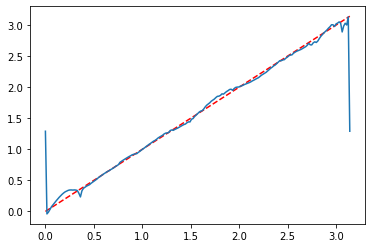

In [20]:
angles = np.linspace(0, np.pi, 201)
test = GratingDataset(angles)


plt.plot(angles, angles, 'r--')
plt.plot( angles, model.forward( test.images).detach())


Ok, this looks like the model is learning pretty well, but theres still an issue with the overlap between small and large angles, which are both being pushed towards $\pi/2$. This can be fixed by making the loss function and / or network output mod pi

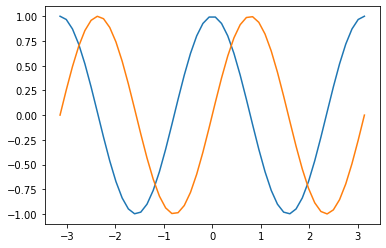

In [25]:
test = np.linspace(-np.pi, np.pi)

plt.plot(test, np.cos(2*test))
plt.plot(test, np.sin(2*test))

In [119]:
def vectorRepresentation( angles):
    """ Implanting angles into Euclidian space, accounting for the fact that 0 = pi
    """
    return torch.stack( (torch.cos(2*angles), torch.sin(2*angles) ) ).T

msloss = torch.nn.MSELoss()


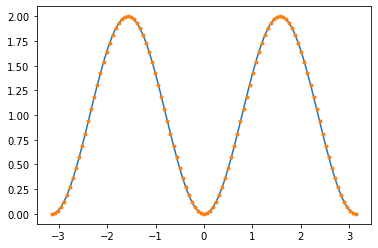

In [137]:
baseAngles = torch.linspace(-np.pi, np.pi, 101)
testAngles = torch.linspace(0, np.pi, 5)

baseVec = vectorRepresentation(baseAngles)
testVec = vectorRepresentation(testAngles)



for test in testVec[0:1]:
    dists = []
    for base in baseVec:
        d = msloss(base, test)
        dists.append(d.numpy())

    plt.plot(baseAngles.numpy(), np.array(dists))
    plt.plot(baseAngles.numpy(), -np.cos(2*baseAngles.numpy()) +1, '.')


Punchline: the vector distance is exactly the cosine of the angle difference! This follows from angle difference identities. I think the vector distance is still easier to implement

## First try with vector distance:
Looks like shit.

In [138]:
model = EstimateAngle.load_from_checkpoint('EstimateAngle/3ms8lyj2/checkpoints/epoch=99-step=8000.ckpt')

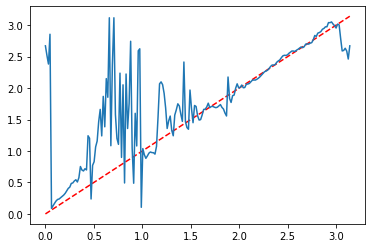

In [145]:
angles = np.linspace(0, np.pi, 201)
test = GratingDataset(angles)


plt.plot(angles, angles, 'r--')
plt.plot( angles, model.forward( test.images).detach() % np.pi  )

In [180]:
%run basicModel.py
model = EstimateAngle.load_from_checkpoint('EstimateAngle/1barre40/checkpoints/epoch=99-step=8000.ckpt')
model.setup(basesize=80)


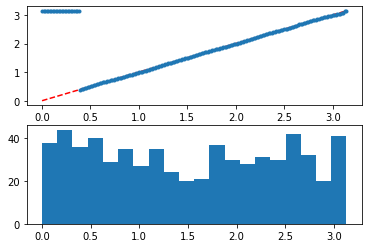

In [181]:
angles = np.linspace(0, np.pi, 201)
test = GratingDataset(angles)

plt.subplots(2, 1)
plt.subplot(2,1,1)
plt.plot(angles, angles, 'r--')
plt.plot( angles, model.forward( test.images).detach(), '.' )

plt.subplot(2,1,2)
plt.hist(model.trainingData.angles, bins=20);




In [201]:
i = 15
model.lossFn(model.forward( test.images).detach()[i], torch.tensor(angles)[i] )

tensor(0.1090, dtype=torch.float64)

It seems strange that the network has so much difficulty learning where to place the cutoff point, when there is a clear signal farther away from zero. It's a strange result

Interestingly, this seems to be a lucky draw. Other seeds don't learn nearly as quickly.

Another option: learn the 2d embedding, then use the angle difference as an objective function.

In [6]:
model = EstimateAngle.load_from_checkpoint('EstimateAngle/2ydkyg3q/checkpoints/epoch=99-step=8000.ckpt')

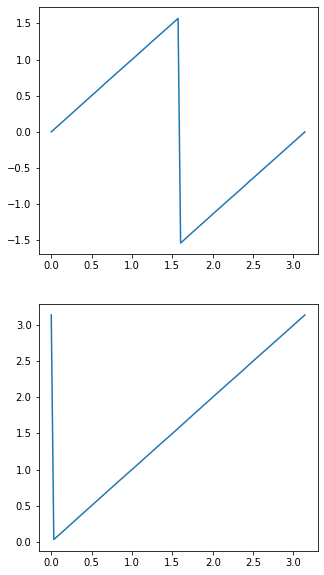

In [26]:
angles = np.linspace(0, np.pi, 101)
test = GratingDataset(angles)

figsize(5,10)
plt.subplots(2, 1)
plt.subplot(2,1,1)
plt.plot(angles, model.decodeAngles( model.forward(test.images) ).detach() )
plt.subplot(2,1,2)
plt.plot(angles, model.decodeAngles( model.forward(test.images) ).detach() % np.pi)


## Finally, a reasonable encoding

Note that mod $\pi$, everything looks great as it should.

The purely decoded one looks the way it does for two reasons:

1. arctan has the range $[-\pi, \pi]$

2. We're using the half-angle encoding, so the range becomes $[-\pi/2, \pi/2]$ with $-\pi/2 = \pi/2$


Out of curiousity, what is the magnitude?

In [35]:
model.setup()

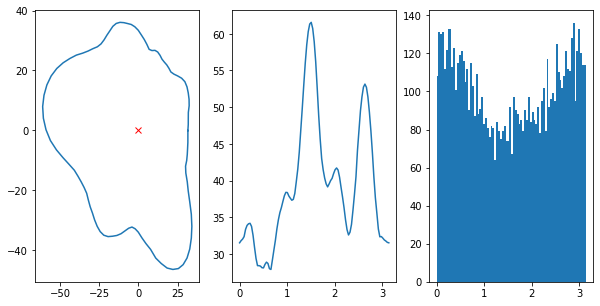

In [38]:
encodings = model.forward( test.images)

figsize(10,5)
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.plot(encodings[:,0].detach(), encodings[:,1].detach())
plt.plot([0], [0], 'rx')

plt.subplot(1,3,2)
plt.plot(angles, torch.norm(encodings, dim=1).detach() )

plt.subplot(1,3,3)
plt.hist(model.trainingData.angles, bins=80);



Not sure if theres a correlation here, but it looks kind of like the radius is largest at the least frequent stimuli.

Question: does the radius reflect the Fisher information? It seems like large radii give more room to make small angle changes, and therefore should correspond to higher Fisher information